In [118]:
import sinter
stats = sinter.stats_from_csv_files('./out/stats.csv')
print(len(stats))

1296


In [119]:
from typing import Optional, List, Any, Tuple, Callable
import math
def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
) -> Optional[sinter.Fit]:
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:
                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['distance']**2))
                log_ps.append(math.log(p_unit))

    if len(log_ps) < 2:
        # Can't interpolate a slope from 1 data point.
        return None

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=math.log(target_p),
        max_extra_squared_error=1,
    )

    return sinter.Fit(
        low=fit.low**2,
        best=fit.best**2,
        high=fit.high**2,
    )


In [120]:
from collections import defaultdict
import matplotlib.pyplot as plt
markers = "ov*sp^<>8PhH+xXDd|" * 100
import matplotlib.colors
colors = list(matplotlib.colors.TABLEAU_COLORS) * 3


noise_model_groups = sinter.group_by(stats, key = lambda stat: str(stat.json_metadata['px'])+ ',' + str(stat.json_metadata['py']) + ',' + str(stat.json_metadata['pz']) + ',' + str(stat.json_metadata['pm']))

noise_model_footprints = defaultdict()

for noise_model_key, noise_model_group in noise_model_groups.items():
    code_name_groups = sinter.group_by(noise_model_group, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))
    noise_model_footprints[noise_model_key] = defaultdict()
    for code_name_key, code_name_group in code_name_groups.items():
        noise_model_footprints[noise_model_key][code_name_key] = extrapolate_footprint_achieving_error_rate(
                code_name_group,
                target_p=10**(-12),
                failure_unit_func=None)


print(noise_model_footprints)

defaultdict(None, {'1.0,1.0,1.0,1.0': defaultdict(None, {('GaugeFloquetColourCode', 1, 1, 0): sinter.Fit(low=318.19271654572367, best=593.9802301300269, high=955.1475856454945), ('GaugeFloquetColourCode', 1, 2, 0): sinter.Fit(low=439.09276592438033, best=851.5011489192628, high=1399.2421094109125), ('GaugeFloquetColourCode', 2, 2, 0): sinter.Fit(low=343.1615253397501, best=646.7198073669605, high=1045.6656092976518), ('GaugeFloquetColourCode', 3, 2, 0): sinter.Fit(low=301.5506152850868, best=558.9849101702455, high=895.2369571261291), ('GaugeFloquetColourCode', 2, 3, 0): sinter.Fit(low=436.06788859232205, best=845.0035712307407, high=1387.983581910534), ('GaugeFloquetColourCode', 2, 1, 0): sinter.Fit(low=297.25493298960424, best=549.9714870411689, high=879.8258838745752), ('GaugeFloquetColourCode', 1, 3, 0): sinter.Fit(low=958.8947002438979, best=1294.4639186817824, high=1680.2861419164701), ('GaugeFloquetColourCode', 3, 3, 0): sinter.Fit(low=551.9714730616199, best=1095.7574617813023,

In [121]:
def get_best_footprint(footprints):
    lowest_footprint = None
    lowest_footprint_name = None
    for code_name, footprint in footprints.items():
        if footprint is not None:
            print(code_name, footprint.best)
        if footprint is not None and (lowest_footprint is None or footprint.best < lowest_footprint):

            lowest_footprint = footprint.best
            lowest_footprint_name = code_name
    return lowest_footprint_name

best_footprints = dict()
for noise_model, footprints in noise_model_footprints.items():
    print(noise_model)
    best_footprints[noise_model] = get_best_footprint(footprints)

    print(noise_model, best_footprints[noise_model])

1.0,1.0,1.0,1.0
('GaugeFloquetColourCode', 1, 1, 0) 593.9802301300269
('GaugeFloquetColourCode', 1, 2, 0) 851.5011489192628
('GaugeFloquetColourCode', 2, 2, 0) 646.7198073669605
('GaugeFloquetColourCode', 3, 2, 0) 558.9849101702455
('GaugeFloquetColourCode', 2, 3, 0) 845.0035712307407
('GaugeFloquetColourCode', 2, 1, 0) 549.9714870411689
('GaugeFloquetColourCode', 1, 3, 0) 1294.4639186817824
('GaugeFloquetColourCode', 3, 3, 0) 1095.7574617813023
('GaugeFloquetColourCode', 3, 1, 0) 587.1964762757851
('GaugeHoneycombCode', 1, 1, 1) 413.4830133481912
('GaugeHoneycombCode', 1, 1, 2) 735.186282758491
('GaugeHoneycombCode', 1, 1, 3) 845.949195979805
('GaugeHoneycombCode', 1, 2, 1) 625.1877208461526
('GaugeHoneycombCode', 1, 2, 2) 595.0486667696232
('GaugeHoneycombCode', 1, 3, 1) 625.2508137922554
('GaugeHoneycombCode', 1, 2, 3) 836.9532059330862
('GaugeHoneycombCode', 1, 3, 2) 1092.9390701492664
('GaugeHoneycombCode', 1, 3, 3) 675.2628973603622
('GaugeHoneycombCode', 2, 1, 1) 564.56836014994

In [123]:
code_name_to_color = {'FloquetColourCode': 1,'HoneycombCode': 10}
x_y_to_color = defaultdict()
x_values = list(  )
y_values = list()
for noise_model, best_footprint in best_footprints.items():
    code_name = (noise_model.split(',')[-2])
    print(best_footprint)
    x_y_to_color[(noise_model.split(',')[-2], noise_model.split(',')[-1])] = code_name_to_color[best_footprint]
    if noise_model.split(',')[-2] not in x_values:
        x_values.append(noise_model.split(',')[-2])
    if noise_model.split(',')[-1] not in y_values:
        y_values.append(noise_model.split(',')[-1])

x_values.sort()
y_values.sort()
y_values = y_values[::-1]
color_matrix = [[0 for i in range(len(y_values))] for j in range(len(x_values))]
for x_val in x_values:
    for y_val in y_values:
        if (x_val, y_val) in x_y_to_color:
            color_matrix[x_values.index(x_val)][y_values.index(y_val)] = x_y_to_color[(x_val, y_val)]


x_values = [float(x) for x in x_values]
y_values = [float(y) for y in y_values]

# go from px,py,pz,pm to x and y coordinate


# go from code_name to color


('GaugeHoneycombCode', 1, 1, 1)


KeyError: ('GaugeHoneycombCode', 1, 1, 1)

In [124]:

def format_code_label(code_name):
    code_name_to_label = {
        'FloquetColourCode': 'FCC',
        'HoneycombCode': 'HCC',
        'GaugeHoneycombCode': 'HCC',
        'GaugeFloquetColourCode': 'FCC'
    }
    label = code_name_to_label.get(code_name[0], code_name)
    formatted_values = ''.join(map(str, code_name[1:]))
    return f'{label}{formatted_values}'


def plot_footprints(footprints,error_model):
    sorted_items = sorted(footprints[error_model].items(), key=lambda item: item[1].best if item[1] is not None else float('inf'))
    code_name_to_color = {'GaugeFloquetColourCode': 'blue', 'GaugeHoneycombCode': 'red'}
    for code_name, footprint in sorted_items:
        
        

        if footprint is not None:
            formatted_label = format_code_label(code_name)

            bars = plt.bar(str(code_name), float(footprint.best), color=code_name_to_color.get(code_name[0], 'black'))
            for bar in bars:
                height = bar.get_height() + 100
                plt.text(bar.get_x() + bar.get_width() / 2.0, height, formatted_label, ha='center', va='bottom', rotation=90)

    # Add labels and title
    plt.xlabel('Codes')
    plt.ylabel('Footprints')
    error_rates = error_model.split(',')
    plt.title(f'error model: px {error_rates[0]} py {error_rates[1]} pz {error_rates[2]} pm {error_rates[3]}')
    plt.xticks([])
    plt.show()



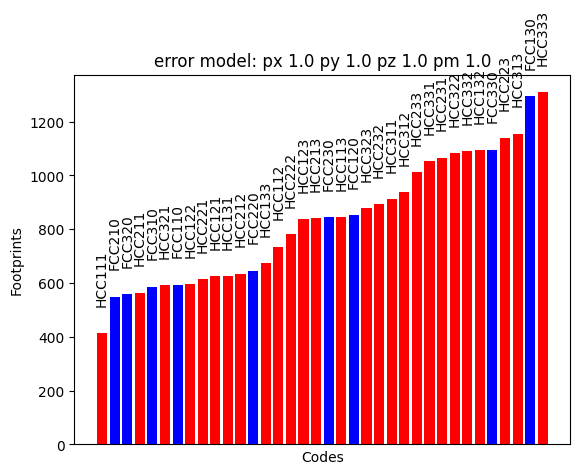

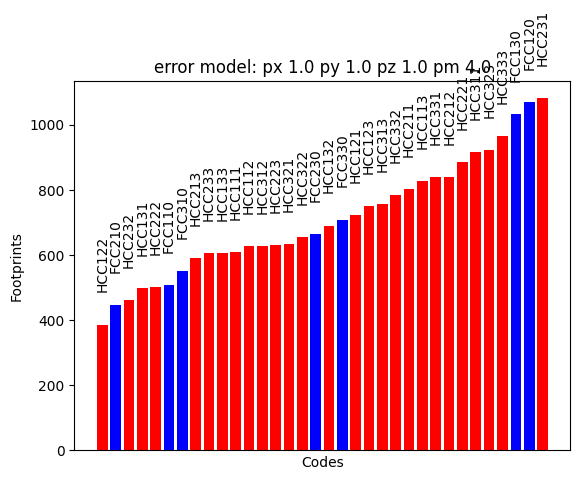

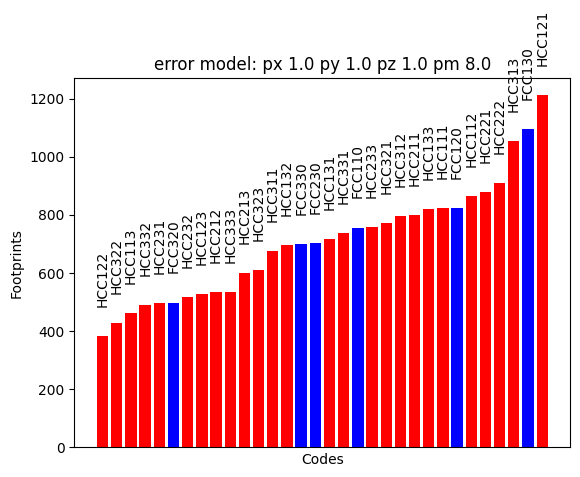

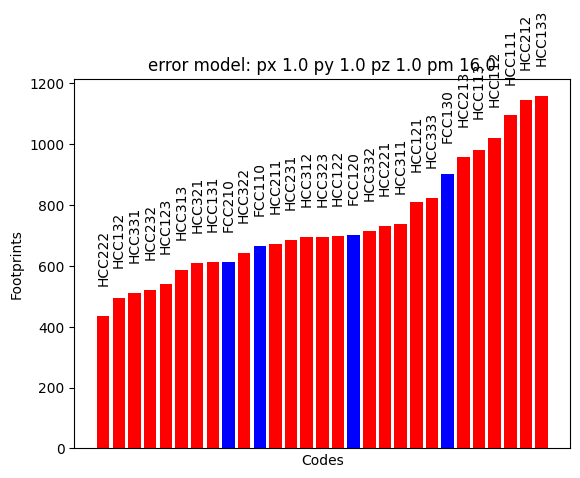

In [125]:
plot_footprints(noise_model_footprints, '1.0,1.0,1.0,1.0')
plot_footprints(noise_model_footprints, '1.0,1.0,1.0,4.0')
plot_footprints(noise_model_footprints, '1.0,1.0,1.0,8.0')
plot_footprints(noise_model_footprints, '1.0,1.0,1.0,16.0')

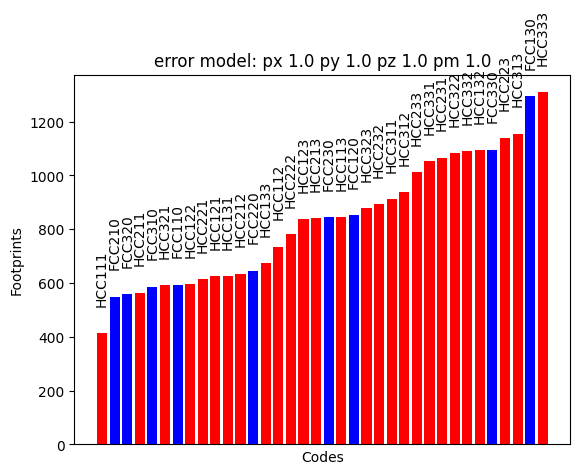

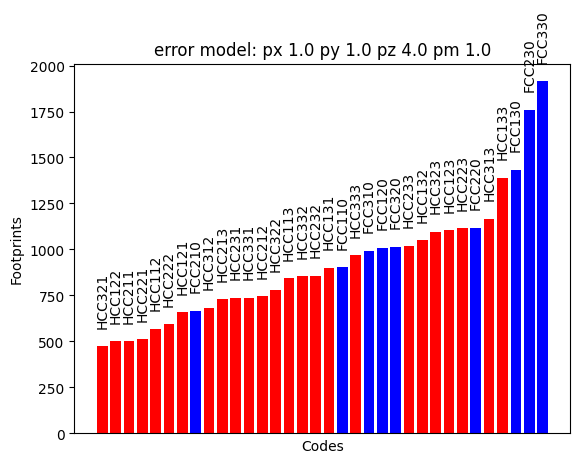

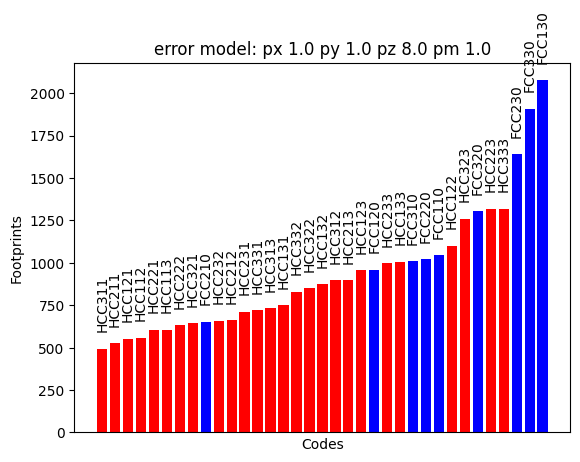

KeyError: '1.0,1.0,16.0,1.0'

In [126]:
plot_footprints(noise_model_footprints, '1.0,1.0,1.0,1.0')
plot_footprints(noise_model_footprints, '1.0,1.0,4.0,1.0')
plot_footprints(noise_model_footprints, '1.0,1.0,8.0,1.0')
plot_footprints(noise_model_footprints, '1.0,1.0,16.0,1.0')

In [101]:
plt.imshow(color_matrix)
plt.xticks(np.arange(len(x_values)), labels=x_values)
plt.yticks(np.arange(len(y_values)), labels=y_values)
plt.xlabel('Z bias')
plt.ylabel('Measurement bias')

NameError: name 'color_matrix' is not defined

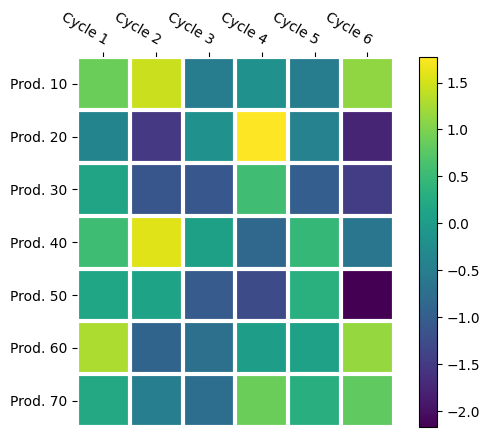

In [153]:
import numpy as np
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

data = np.random.randn(7, 6)
y = [f"Prod. {i}" for i in range(10, 80, 10)]
x = [f"Cycle {i}" for i in range(1, 7)]
qrates = list("ABCDEFG")
norm = matplotlib.colors.BoundaryNorm(np.linspace(-3.5, 3.5, 8), 7)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, _ = heatmap(data, y, x)



In [152]:
imshow
print(data)
print(colors)
#im, _ = heatmap(colors, y_cords, x_cords)


[[-0.07151069  1.18280717 -0.95828172  0.5717842   0.53571285  0.63972755]
 [-0.35030957  0.83208399 -1.3920888  -0.25202288  1.32337813 -0.27991457]
 [-0.99903546 -1.1257055   0.29360627 -0.11919822 -0.2198939   0.92073018]
 [-0.08638644  0.93319565  0.75481009 -1.45229548  1.12567024  0.6403062 ]
 [ 1.2766022  -0.81366911 -0.84092399 -0.29938742 -0.94413404  0.79590808]
 [-0.64452359 -0.38958075 -0.12229497 -0.19471646  0.21670726  0.72245511]]
[1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 10, 10, 1, 10, 10, 10]
